In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cicles dev
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    X_train = X_train.transpose(0, 3, 1, 2)
    X_test = X_test.transpose(0, 3, 1, 2)
    X_val = X_val.transpose(0, 3, 1, 2)
    X_dev = X_dev.transpose(0, 3, 1, 2)

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
dev data shape:  (500, 3, 32, 32)
dev labels shape:  (500,)


In [4]:
from layers.BatchNorm import SpatialBatchNorm
from layers.Conv import Conv2DCython
from layers.Dense import Dense
from layers.Flatten import Flatten
from layers.MaxPool import MaxPool2DCython
from layers.Dropout import Dropout
from model.Model import Model
from utils.model_loss import cross_entropy_loss_npdl

# paramètres de convolution, à modifier au besoin
filter_size = 5
channels = 3
stride = 1
p_dropout = 0.1
pad = int((filter_size - 1)/2)

# paramètres dense
num_classes = 10

def create_Nlayer_cnn(num_filter_layer1, num_filter_layer2, fc_size, init_weight_scale):
    model = Model()
    
    conv1 = Conv2DCython(num_filter_layer1, filter_size=filter_size, channels=channels, padding=pad, weight_scale=init_weight_scale)
    batchnorm1 = SpatialBatchNorm(num_filter_layer1, activation='relu')
    dropout1 = Dropout(drop_rate=p_dropout)
    maxpool1 = MaxPool2DCython(pooling_size=2, stride=2)

    conv2 = Conv2DCython(num_filter_layer2, filter_size=filter_size, channels=num_filter_layer1, padding=pad, weight_scale=init_weight_scale)
    batchnorm2 = SpatialBatchNorm(num_filter_layer2, activation='relu')
    dropout2 = Dropout(drop_rate=p_dropout)
    maxpool2 = MaxPool2DCython(pooling_size=2, stride=2)
    
    conv_fc1 = Conv2DCython(fc_size, filter_size=8, channels=num_filter_layer2, weight_scale=init_weight_scale, activation='relu')
    dropout3 = Dropout(drop_rate=p_dropout)
    conv_fc2 = Conv2DCython(num_classes, filter_size=1, channels=fc_size, weight_scale=init_weight_scale)
    flatten = Flatten()
    
    model.add(conv1)
    model.add(batchnorm1)
    model.add(dropout1)
    model.add(maxpool1)

    model.add(conv2)
    model.add(batchnorm2)
    model.add(dropout2)
    model.add(maxpool2)

    model.add(conv_fc1)
    model.add(dropout3)
    model.add(conv_fc2)
    model.add(flatten)
    model.add_loss(cross_entropy_loss_npdl)
    
    return model

In [5]:
reg = 1e-2 # à ajuster au besoin
model = create_Nlayer_cnn(32, 16, 400, reg)

model.load_weights("cifar10")

item = 1
test_image = X_test[item].reshape(1,3,32,32)
test_image_target = y_test[item]

def softmax(scores):
    stable_scores = scores - np.max(scores, axis=1)[:, None]
    exp_scores = np.exp(stable_scores)
    softmax_output = exp_scores / np.sum(exp_scores, axis=1)[:, None]
    return softmax_output

print(softmax(model.forward_npdl(test_image, mode='test')))

[[3.77667015e-02 2.32332370e-01 5.03652921e-04 6.21384699e-04
  3.23105196e-04 7.43691450e-05 2.00828942e-04 7.92243518e-05
  7.13416315e-01 1.46820474e-02]]


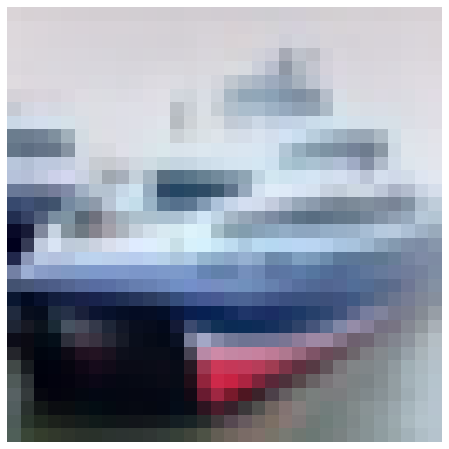

8


In [6]:
from visualization.utils import visualize_as_grid

def show_image(X): 
    W1 = X.transpose(0, 2, 3, 1)
    plt.imshow(visualize_as_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()
    
def show_grayscale(X):
    plt.imshow(X, cmap='gray', vmin=np.min(X), vmax=np.max(X))
    plt.gca().axis('off')
    plt.show()
    
show_image(test_image)
print(test_image_target)

# FGSM

In [7]:
from utils.adverserial_attack import fgsm, jsma, confidence

image_adv, perturb = fgsm(model, test_image, 1, 5)

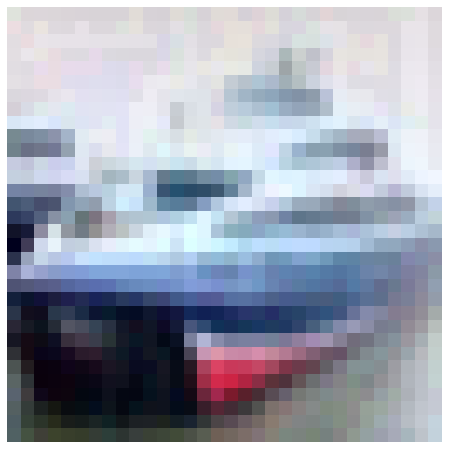

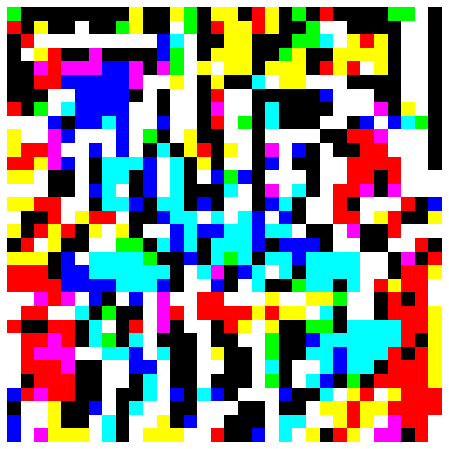

In [8]:
show_image(image_adv)
show_image(perturb)

In [9]:
print(model.predict(image_adv))
print(confidence(model, image_adv))

[1]
0.8160313800032944


In [10]:
from utils.adverserial_attack import mean_attack_error

mse_model = mean_attack_error(model, test_image, image_adv)

inputs
0.01910228228014699
Conv2DCython
0.006776348048701293
SpatialBatchNorm
0.005169609683179203
Dropout
0.005169609683179203
MaxPool2DCython
0.008119076027827882
Conv2DCython
0.012889779658483739
SpatialBatchNorm
0.012711332444145278
Dropout
0.012711332444145278
MaxPool2DCython
0.01988808680585042
Conv2DCython
0.023411663922148752
Dropout
0.023411663922148752
Conv2DCython
0.05594185906170179
Flatten
0.05594185906170179


# Saliency Map Attack

In [11]:
print(model.predict(test_image))
print(confidence(model, test_image))
print(softmax(model.forward_npdl(test_image, mode='test')))

[8]
0.7134163153785397
[[3.77667015e-02 2.32332370e-01 5.03652921e-04 6.21384699e-04
  3.23105196e-04 7.43691450e-05 2.00828942e-04 7.92243518e-05
  7.13416315e-01 1.46820474e-02]]


In [12]:
scores = model.forward_npdl(test_image, mode='test')
image_adv = jsma(model, test_image, scores, 1, 10)

In [13]:
print(model.predict(image_adv))
print(confidence(model, image_adv))
print(softmax(model.forward_npdl(image_adv, mode='test')))

[1]
0.4733270129977584
[[3.35068363e-02 4.73327013e-01 3.86816906e-04 4.60192471e-04
  2.92932723e-04 5.92262804e-05 2.00853129e-04 6.91456242e-05
  4.68207921e-01 2.34890629e-02]]


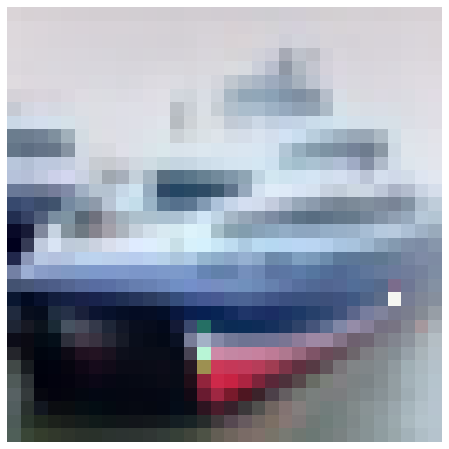

In [14]:
show_image(image_adv)

In [15]:
from utils.adverserial_attack import mean_attack_error

mse_model = mean_attack_error(model, test_image, image_adv)

inputs
0.0009489728396640069
Conv2DCython
0.001487152917642768
SpatialBatchNorm
0.0013044001724466883
Dropout
0.0013044001724466883
MaxPool2DCython
0.00225655162633121
Conv2DCython
0.00603798504922152
SpatialBatchNorm
0.0066295117638932935
Dropout
0.0066295117638932935
MaxPool2DCython
0.009621137441385562
Conv2DCython
0.01107839193827474
Dropout
0.01107839193827474
Conv2DCython
0.029710438590093043
Flatten
0.029710438590093043


# Simple blackbox attack

In [16]:
from utils.adverserial_attack import simba

In [17]:
print(model.predict(test_image))
print(confidence(model, test_image))
print(softmax(model.forward_npdl(test_image, mode='test')))

[8]
0.7134163153785397
[[3.77667015e-02 2.32332370e-01 5.03652921e-04 6.21384699e-04
  3.23105196e-04 7.43691450e-05 2.00828942e-04 7.92243518e-05
  7.13416315e-01 1.46820474e-02]]


In [18]:
original_predictions = softmax(model.forward_npdl(test_image, mode='test')).reshape(-1,)
original_target = model.predict(test_image)

delta = simba(model, test_image[0], original_predictions, original_target, eps=2)[np.newaxis,:,:,:]
image_adv = test_image[0] + delta

In [19]:
print(model.predict(image_adv))
print(confidence(model, image_adv))
print(softmax(model.forward_npdl(image_adv, mode='test')))

[1]
0.4629720040312138
[[4.88143477e-02 4.62972004e-01 6.85085556e-04 7.46513570e-04
  4.49721976e-04 1.00961359e-04 2.73069390e-04 1.46946774e-04
  4.62895241e-01 2.29161087e-02]]


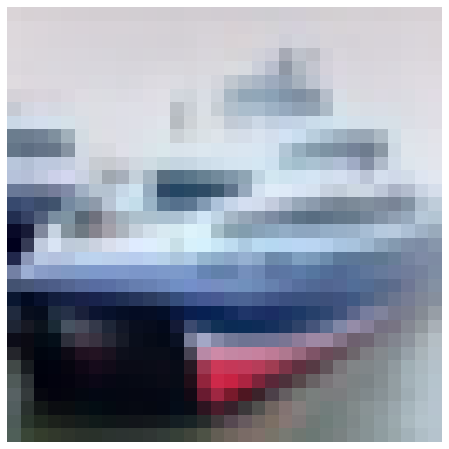

In [20]:
show_image(test_image)

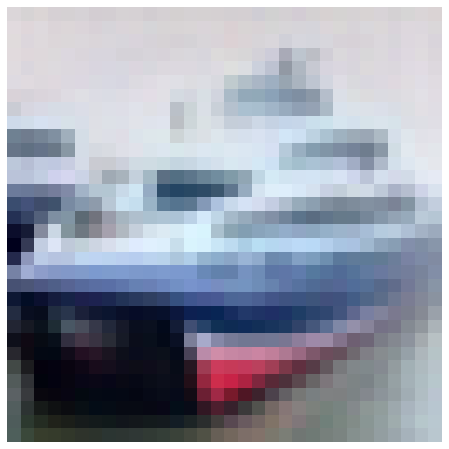

In [21]:
show_image(image_adv)

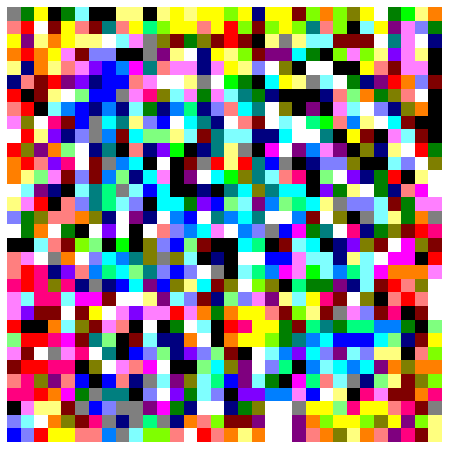

In [22]:
show_image(delta)

In [23]:
from utils.adverserial_attack import mean_attack_error

mse_model = mean_attack_error(model, test_image, image_adv)

inputs
0.005237122544118718
Conv2DCython
0.0020078403912824326
SpatialBatchNorm
0.0015309826929326552
Dropout
0.0015309826929326552
MaxPool2DCython
0.0024600516161860852
Conv2DCython
0.0041442073830449
SpatialBatchNorm
0.004079391613132588
Dropout
0.004079391613132588
MaxPool2DCython
0.0063994974129213825
Conv2DCython
0.008854292189327408
Dropout
0.008854292189327408
Conv2DCython
0.021119566661402647
Flatten
0.021119566661402647


# Cartes d'activation

In [24]:
X_data = model.forward_npdl(test_image, mode='test', all=True)
X_adv_data = model.forward_npdl(image_adv, mode='test', all=True)

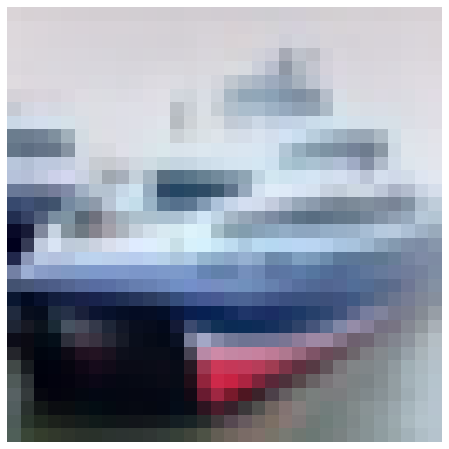

In [25]:
show_image(test_image)

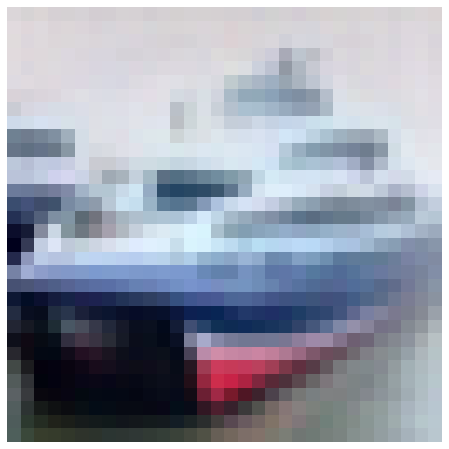

In [26]:
show_image(image_adv)

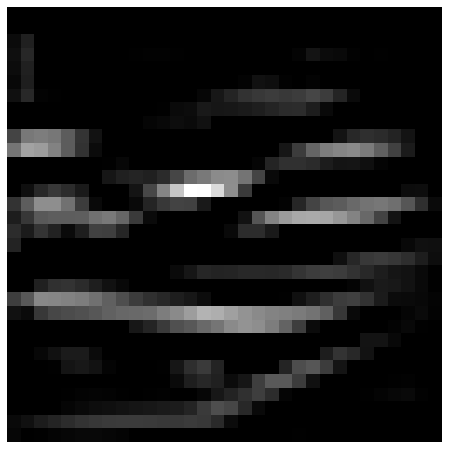

In [27]:
show_grayscale(X_data['L1'][0, 14, :, :])

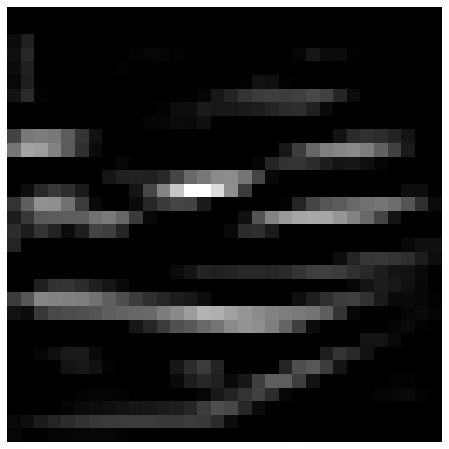

In [28]:
show_grayscale(X_adv_data['L1'][0, 14, :, :])

# Simple blackbox attack sur plusieurs images

Permet d'obtenir des valeurs moyennes sur les variations dans les cartes d'activation

In [29]:
import numpy as np
from utils.adverserial_attack import print_mse

In [30]:
nb_samples = 50
test_set_x = X_test[:nb_samples]
test_set_y = y_test[:nb_samples]

original_predictions = softmax(model.forward_npdl(test_set_x, mode='test'))
original_target = model.predict(test_set_x)

In [ ]:
# On utiLise une for loop parce que nous avons implémenté simba pour calculer image_adv d'une seule image
adv_set_x = []
for i in range(nb_samples):
    delta = simba(model, test_set_x[i], original_predictions[i], original_target[i], eps=15)[np.newaxis,:,:,:]
    image_adv = test_set_x[i] + delta
    adv_set_x.append(image_adv[0])
    print(str(i) + '/' + str(nb_samples))

0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50


In [ ]:
# Calculer l'erreur moyenne moyenne des cartes d'activation de chaque couche
adv_set_x = np.array(adv_set_x)
mse_model = mean_attack_error(model, test_set_x, adv_set_x)

In [ ]:
print_mse(mse_model, model)